In [1]:
import scipy
import scipy.io
import scipy.integrate
import numpy as np
from numpy import linalg
from pydmd import DMD
import matplotlib.pyplot as plt
from matplotlib import cm
import imageio
import math
import csv
import pandas as pd

In [2]:
h_trunc = 40
l_trunc = 140

i_dmd = 0
i_pod = 5

In [11]:
with open("pod_10_10.csv", mode='r') as csvfile:
    data = csv.reader(csvfile)
    pod = list(data)
with open("dmd_10.csv", mode='r') as csvfile:
    data = csv.reader(csvfile)
    dmd = list(data)
with open("dmd_freqs.csv", mode='r') as csvfile:
    data = csv.reader(csvfile)
    freqs = list(data)
print(np.shape(pod[0]),np.shape(dmd[0]),len(dmd),len(pod))

len_d = 10 #int(len(dmd)/2) #number of modes (dmd, pod in that order) from data
len_p = int(len(pod)/2)
projections = np.zeros((len_d,len_p))
for i in range(0,len_p):
    for j in range(0,len_d):
        #manipulating modes so both datasets are spatially aligned (dmd requires fliplr)
        p_temp = pod[i*2]
        d_temp = np.reshape(np.fliplr(np.reshape(dmd[len(dmd)-2-j*2],(h_trunc,l_trunc))),(h_trunc*l_trunc))
        psi_p = np.array([float(n) for n in p_temp])
        psi_d = np.array([float(n) for n in d_temp])
        psi_p_t = np.transpose(psi_p)
        psi_d_t = np.transpose(psi_d)
        # normalising and projecting pod onto dmd modes to find their affinity
        projections[j,i] = abs(np.dot(psi_p_t,psi_d)/(math.sqrt(np.dot(psi_p_t,psi_p))*math.sqrt(np.dot(psi_d_t,psi_d))))
        
projections = np.rot90(np.fliplr(projections))

(5600,) (5600,) 20 20


In [ ]:
# visualise difference between two modes through subtraction
test = np.fliplr(np.reshape(dmd[len(dmd)-2-i_dmd*2],(h_trunc,l_trunc)))
plt.set_cmap("bwr")
fig, ax = plt.subplots()
cs = ax.contourf(test, levels=20)
ax.set_title('DMD Mode '+str(i_dmd))
fig.colorbar(cs, ax=ax)
plt.show()

test = np.reshape(pod[i_pod*2],(h_trunc,l_trunc))
plt.set_cmap("bwr")
fig, ax = plt.subplots()
cs = ax.contourf(test, levels=20)
ax.set_title('POD Mode '+str(i_pod))
fig.colorbar(cs, ax=ax)
plt.show()


pod_data = [float(i) for i in pod[i_pod*2]]
pod_data = np.reshape(pod_data,(h_trunc,l_trunc))
dmd_data = [float(i) for i in dmd[len(dmd)-2-i_dmd*2]]
dmd_data = np.fliplr(np.reshape(dmd_data,(h_trunc,l_trunc)))

diff = np.add(pod_data,dmd_data) # np.subtract 
plt.set_cmap("BrBG")
fig, ax = plt.subplots()
cs = ax.contourf(diff, levels=20)
ax.set_title('Add DMD, POD')
fig.colorbar(cs, ax=ax)
plt.show()

In [ ]:
# verification of projection values for plot below
psi_p = np.array([float(n) for n in np.reshape(np.reshape(pod[i_pod*2],(h_trunc,l_trunc)),(h_trunc*l_trunc))])
psi_d = np.array([float(n) for n in np.reshape(np.fliplr(np.reshape(dmd[len(dmd)-2-i_dmd*2],(h_trunc,l_trunc))),(h_trunc*l_trunc))])
psi_p_t = np.transpose(psi_p)
psi_d_t = np.transpose(psi_d)
        
print(np.dot(psi_p_t,psi_d)/(math.sqrt(np.dot(psi_p_t,psi_p))*math.sqrt(np.dot(psi_d_t,psi_d)))) #projection
print(np.dot(psi_p_t,psi_p)/(math.sqrt(np.dot(psi_p_t,psi_p))*math.sqrt(np.dot(psi_d_t,psi_d))))
print(np.dot(psi_d_t,psi_d)/(math.sqrt(np.dot(psi_p_t,psi_p))*math.sqrt(np.dot(psi_d_t,psi_d))))
print(np.dot(psi_d_t,psi_d)/np.dot(psi_p_t,psi_p))

In [12]:
def sort():
    # function finds order that 'projections' must be arranged into to organise largest values through brute force
    max_row = np.zeros(len_p)
    for j in range(len_p):
        max_row[j] = 0
        for i in range(len_d):
            if projections[j,i] > max_row[j]:
                max_row[j] = projections[j,i]

    max_col = np.zeros(len_d)
    for i in range(len_d):
        max_col[i] = freqs[i][0]

#    for i in range(len_d):     THIS BLOCK OF CODE ORDERS BY AFFINITY, NOT BY FREQUENCY
#        max_col[i] = 0
#        for j in range(len_p):
#            if projections[j,i] > max_col[i]:
#                max_col[i] = projections[j,i]

    sort_row = (-max_row).argsort()
    sort_col = (max_col).argsort()
    return(sort_row, sort_col)

In [13]:
print(sort()[0], sort()[1])

[0 6 3 2 9 4 1 7 5 8] [8 9 6 7 4 5 2 3 0 1]


[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[2.92 2.92 5.5  5.5  6.68 6.68 7.86 7.86 9.82 9.82]
[8 9 6 7 4 5 2 3 0 1]


<Figure size 432x288 with 0 Axes>

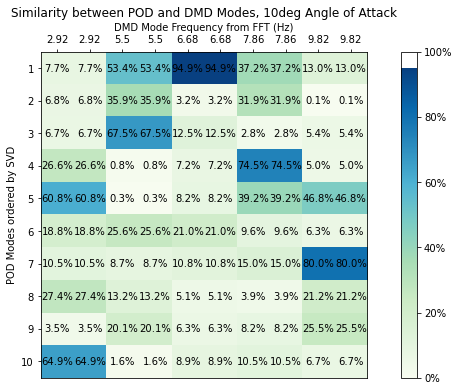

In [16]:
from matplotlib.cm import ScalarMappable

sort() #run sorting function to order projections based on affinity

df = pd.DataFrame(projections) # transfer projections to Pandas dataframe for ordering
df = df[sort()[1]]
sort_projections = df.to_numpy() # return to numpy array for plotting

plt.set_cmap("GnBu")
fig, ax = plt.subplots(figsize=(12,6))
plt.title('Similarity between POD and DMD Modes, ' + '10deg Angle of Attack')
im = ax.imshow(sort_projections)
cbar = fig.colorbar(im, ticks=[0,0.2,0.4,0.6,0.8,1])
cbar.set_ticks([0,0.2,0.4,0.6,0.8,1])
cbar.set_ticklabels(["0%","20%","40%","60%","80%","100%"])

f_arr = np.zeros(len(freqs))
print(f_arr)
for i in range(len(f_arr)):
    f_arr[i] = str(round(float(freqs[i][0]),2))
f_arr = f_arr[sort()[1]]
print(f_arr)
print(sort()[1])

plt.xlabel('DMD Mode Frequency from FFT (Hz)')
plt.ylabel('POD Modes ordered by SVD')
ax.set_xticks(np.arange(0,len_d),f_arr)
ax.set_xticklabels(f_arr)
ax.set_yticks(np.arange(0,len_p))
ax.set_yticklabels(np.arange(1,len_p+1))
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")
ax.xaxis.set_label_position('top')
ax.xaxis.tick_top()

for j in range(len_p):
    for i in range(len_d):
        # displaying projections as percentage of affinity for each combination necessitates formatting
        text = ax.text(i, j, format(round(sort_projections[j, i],3),'.1%'),ha="center", va="center", color="black")

plt.show()